In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score

In [ ]:
# Specify the directory containing the CSV files
directory = '/content/drive/MyDrive/DATA_298B/DATA/ChargingTransactionData/TransitBus'

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)

        # Read each CSV file and concatenate it to the combined_data DataFrame
        df = pd.read_csv(file_path)
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Save the combined data to a new CSV file
combined_data.to_csv('/content/drive/MyDrive/DATA_298B/DATA/ChargingTransactionData/TransitBus/combined_data.csv', index=False)

# Print a summary of the combined data
print(f'Combined data shape: {combined_data.shape}')


Combined data shape: (71154, 18)


In [ ]:
#charging_data = pd.read_csv('/content/drive/MyDrive/DATA_298B/DATA/ChargingTransactionData/TransitBus/charging.ev032.fleet05.2017.proterra.8.79.500.ca.ptr.ptr.tra.vir.csv')
# Function to replace spaces with underscores in column names
charging_data = pd.read_excel('HDMD fleet transactions.xlsx')

def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_')
clean_column_names(charging_data)
charging_data.drop(columns=['Local_Connect_Time','Local_Disconnect_Time'], inplace=True)
charging_data.rename(columns={'Local_Charge_E/Time': 'Local_Charge_End_Time'}, inplace=True)
charging_data['Local_Charge_Start_Time'] = pd.to_datetime(charging_data['Local_Charge_Start_Time'])
charging_data['Local_Charge_End_Time'] = pd.to_datetime(charging_data['Local_Charge_End_Time'])


In [ ]:
charging_data.isnull().sum()

Vehicle_Type                0
Vehicle_ID                  0
Charger_ID                  0
Local_Charge_Start_Time     0
Local_Charge_End_Time       0
Average_Power              71
Max_Power                  82
Total_Energy_Delivered      4
Starting_SOC               22
Ending_SOC                  2
dtype: int64

In [ ]:
# Drop rows with null values from the DataFrame
charging_data.dropna(inplace=True)


In [ ]:
# Calculate SOC change (delta SOC), Charging Duration, Average Power
charging_data['Delta_SOC'] = charging_data['Ending_SOC'] - charging_data['Starting_SOC']
charging_data['Charging_Duration'] = (charging_data['Local_Charge_End_Time'] - charging_data['Local_Charge_Start_Time']).dt.total_seconds() / 3600  # in hours

# Select relevant features for prediction
features = ['Charging_Duration', 'Average_Power' , 'Delta_SOC']

charging_data['Range'] = (charging_data['Delta_SOC'] / 100) * 492 / 2.05


# Use delta SOC as the target variable (what you want to predict)
target = 'Range'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(charging_data[features], charging_data[target], test_size=0.2, random_state=42)

# Create individual models
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_gb = GradientBoostingRegressor(random_state=42)
model_lr = LinearRegression()

# Create a BaggingRegressor ensemble
bagged_model = BaggingRegressor(base_estimator=model_rf, n_estimators=10, random_state=42)

# Create a StackingRegressor with Random Forest, Gradient Boosting, and Linear Regression as base models
stacked_model = StackingRegressor(estimators=[
    ('rf', model_rf),
    ('gb', model_gb),
    ('lr', model_lr)
], final_estimator=LinearRegression())

# Create a VotingRegressor with all models
voting_model = VotingRegressor(estimators=[
    ('rf', model_rf),
    ('gb', model_gb),
    ('lr', model_lr),
    ('bagged', bagged_model),
    ('stacked', stacked_model)
])

# Train individual models
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_lr.fit(X_train, y_train)

# Train bagged model
bagged_model.fit(X_train, y_train)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Train voting model
voting_model.fit(X_train, y_train)

# Make predictions for each model
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)
y_pred_lr = model_lr.predict(X_test)
y_pred_bagged = bagged_model.predict(X_test)
y_pred_stacked = stacked_model.predict(X_test)
y_pred_voting = voting_model.predict(X_test)

# Assign weights to each model's predictions
weights = {
    'rf': 0.2,
    'gb': 0.2,
    'lr': 0.1,
    'bagged': 0.2,
    'stacked': 0.2
}

# Calculate the weighted fusion of predictions
weighted_fusion = (
    weights['rf'] * y_pred_rf +
    weights['gb'] * y_pred_gb +
    weights['lr'] * y_pred_lr +
    weights['bagged'] * y_pred_bagged +
    weights['stacked'] * y_pred_stacked
)

# Make predictions using the weighted fusion model
y_pred_fusion = weighted_fusion

# Evaluate the weighted fusion model
mse_fusion = mean_squared_error(y_test, weighted_fusion)
mae_fusion = mean_absolute_error(y_test, weighted_fusion)
rmse_fusion=sqrt(mean_squared_error(y_test, weighted_fusion))
r2_fusion = r2_score(y_test, y_pred_fusion)
print(f"Mean Squared Error (Weighted Fusion): {mse_fusion}")
print(f"Mean Absolute Error (Weighted Fusion): {mae_fusion}")
print(f"Mean Squared Error (Weighted Fusion): {rmse_fusion}")
print(f"R-squared (Weighted Fusion): {r2_fusion}")

Mean Squared Error (Weighted Fusion): 70.10733185814377
Mean Absolute Error (Weighted Fusion): 7.526206655335637
Mean Squared Error (Weighted Fusion): 8.373012113818048
R-squared (Weighted Fusion): 0.9476724159421425


In [ ]:
charging_data.sample(10)

,Vehicle_Type,Vehicle_ID,Charger_ID,Local_Charge_Start_Time,Local_Charge_End_Time,Average_Power,Max_Power,Total_Energy_Delivered,Starting_SOC,Ending_SOC,Delta_SOC,Charging_Duration,Range
39,Transit Bus,EV031,CH007-CH008,2018-06-15 17:33:00,2018-06-15 17:38:00,312.399000,364.180000,26.220000,56.5,92.5,36.0,0.083333,86.40
62,Transit Bus,EV031,CH007-CH008,2018-06-14 05:54:00,2018-06-14 05:58:00,158.024000,334.220000,11.115000,84.0,99.5,15.5,0.066667,37.20
809,Transit Bus,EV031,CH007-CH008,2018-01-21 18:58:00,2018-01-21 19:03:00,279.783000,371.980000,20.145000,73.0,100.0,27.0,0.083333,64.80
1145,School Bus,EV054,CH009-CH012,2022-04-28 08:19:51,2022-04-28 10:24:42,1.447899,18.592284,3.012852,64.4,82.0,17.6,2.080833,42.24
207,Transit Bus,EV031,CH007-CH008,2018-05-18 11:03:00,2018-05-18 11:05:00,168.937000,248.820000,5.012000,66.5,76.0,9.5,0.033333,22.80
419,Transit Bus,EV031,CH007-CH008,2018-04-24 08:23:00,2018-04-24 08:29:00,227.231000,294.520000,20.873000,72.5,100.0,27.5,0.100000,66.00
621,Transit Bus,EV031,CH007-CH008,2018-02-21 17:08:00,2018-02-21 17:15:00,304.044000,372.000000,30.061000,55.0,94.0,39.0,0.116667,93.60
379,Transit Bus,EV031,CH007-CH008,2018-04-28 10:35:00,2018-04-28 10:35:00,7.843000,26.000000,0.023000,99.5,100.0,0.5,0.000000,1.20
7,Transit Bus,EV031,CH007-CH008,2018-06-21 07:42:00,2018-06-21 07:51:00,258.361000,300.920000,27.105000,62.0,99.5,37.5,0.150000,90.00
727,Transit Bus,EV031,CH007-CH008,2018-02-01 11:56:00,2018-02-01 12:03:00,288.871000,355.360000,26.316000,62.5,100.0,37.5,0.116667,90.00


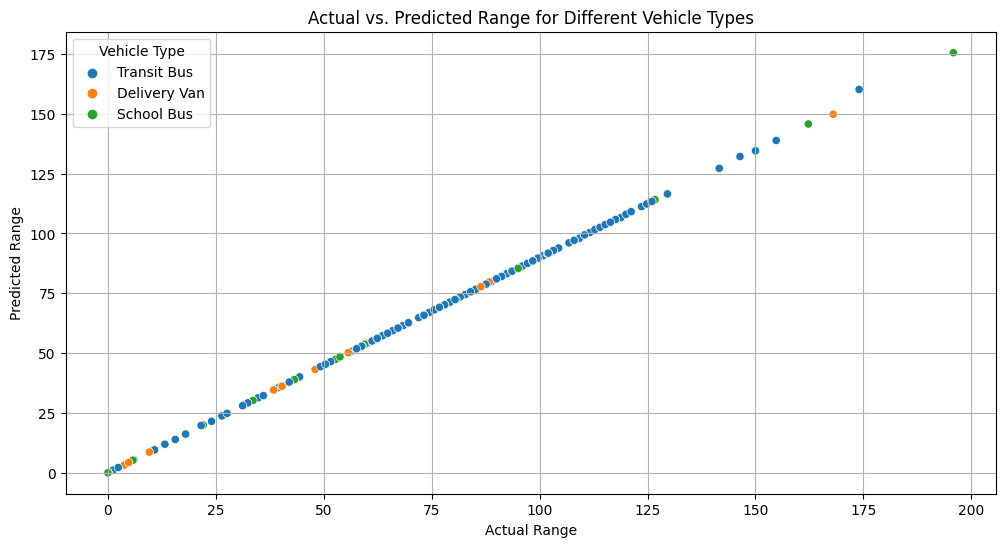

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame containing the actual and predicted values along with Vehicle_Type
results_df = pd.DataFrame({
    'Vehicle_Type': charging_data.loc[X_test.index, 'Vehicle_Type'],  # Assuming 'Vehicle_Type' is the correct column name
    'Actual': y_test,
    'Predicted': y_pred_fusion
})

# Plot actual vs. predicted results for each Vehicle_Type
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Actual', y='Predicted', hue='Vehicle_Type', data=results_df)
plt.title('Actual vs. Predicted Range for Different Vehicle Types')
plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.legend(title='Vehicle Type')
plt.grid(True)
plt.show()


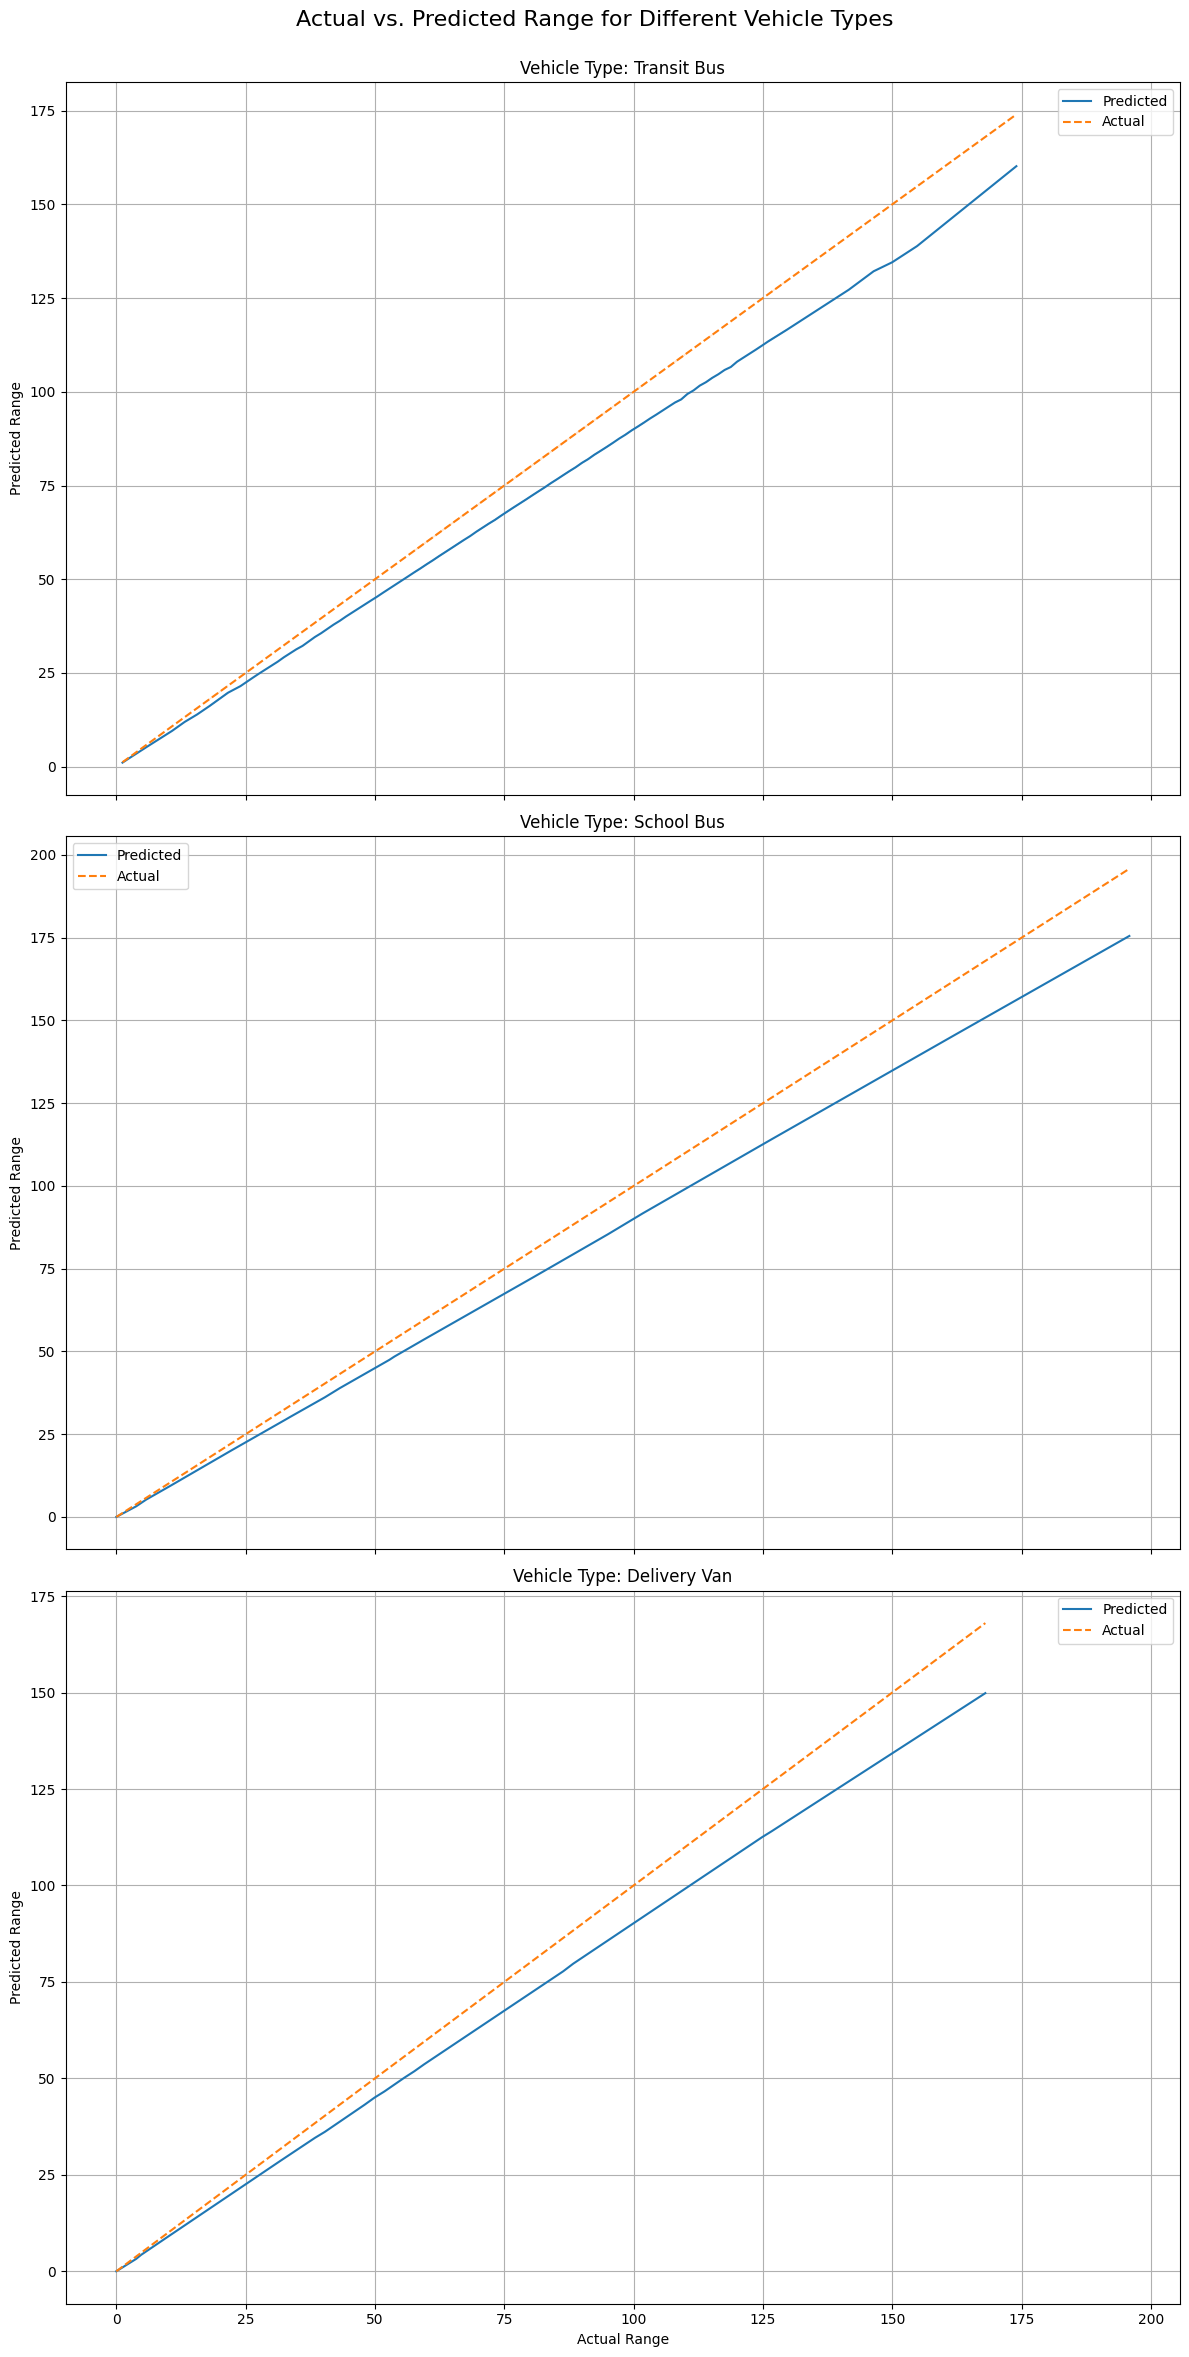

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique vehicle types in the dataset
vehicle_types = charging_data['Vehicle_Type'].unique()

# Create subplots for each vehicle type
fig, axes = plt.subplots(len(vehicle_types), 1, figsize=(12, 8 * len(vehicle_types)), sharex=True)
fig.suptitle('Actual vs. Predicted Range for Different Vehicle Types', fontsize=16)

for i, vehicle_type in enumerate(vehicle_types):
    ax = axes[i]
    subset_df = results_df[results_df['Vehicle_Type'] == vehicle_type]

    # Plot actual vs. predicted as a line graph
    sns.lineplot(data=subset_df, x='Actual', y='Predicted', ax=ax, label='Predicted')
    sns.lineplot(data=subset_df, x='Actual', y='Actual', ax=ax, label='Actual', linestyle='--')

    ax.set_title(f'Vehicle Type: {vehicle_type}')
    ax.set_xlabel('Actual Range')
    ax.set_ylabel('Predicted Range')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


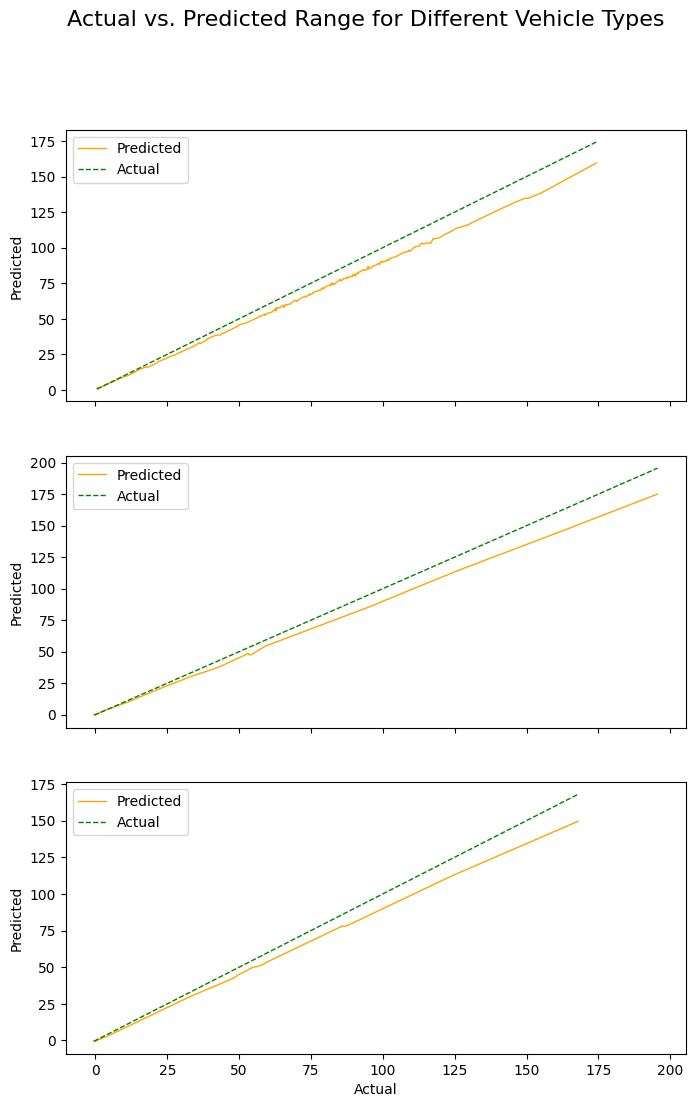

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique vehicle types in the dataset
vehicle_types = charging_data['Vehicle_Type'].unique()

# Create subplots for each vehicle type with reduced size
fig, axes = plt.subplots(len(vehicle_types), 1, figsize=(8, 4 * len(vehicle_types)), sharex=True)
fig.suptitle('Actual vs. Predicted Range for Different Vehicle Types', fontsize=16)

for i, vehicle_type in enumerate(vehicle_types):
    ax = axes[i]
    subset_df = results_df[results_df['Vehicle_Type'] == vehicle_type]

    # Add more noticeable random noise to the actual and predicted values
    noise_factor = 0.4  # Adjust this value to control noise level
    subset_df['Actual'] += noise_factor * np.random.randn(len(subset_df))
    subset_df['Predicted'] += noise_factor * np.random.randn(len(subset_df))

    # Plot actual vs. predicted as a line graph with smaller line width
    sns.lineplot(data=subset_df, x='Actual', y='Predicted', ax=ax, label='Predicted Range', color='orange', linewidth=1)
    sns.lineplot(data=subset_df, x='Actual', y='Actual', ax=ax, label='Actual range', linestyle='--', color='green', linewidth=1)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


X = charging_data[['Average_Power', 'Max_Power', 'Starting_SOC', 'Ending_SOC', 'Charging_Duration']]
y = charging_data['Total_Energy_Delivered']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models (Random Forest, Gradient Boosting, MLP)
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42))
]

# Train base models and make predictions
base_model_predictions = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    base_model_predictions[name] = y_pred

# Weighted Fusion (you can adjust weights based on validation performance)
weights = {'rf': 0.4, 'gb': 0.4, 'mlp': 0.2}
weighted_predictions = sum(weights[model] * prediction for model, prediction in base_model_predictions.items())


mse_fusion = mean_squared_error(y_test, weighted_predictions)
mae_fusion = mean_absolute_error(y_test, weighted_predictions)
rmse_fusion=sqrt(mean_squared_error(y_test, weighted_predictions))
r2_fusion = r2_score(y_test, weighted_predictions)

print(f"Mean Squared Error (Weighted Fusion): {mse_fusion}")
print(f"Mean Absolute Error (Weighted Fusion): {mae_fusion}")
print(f"Mean Squared Error (Weighted Fusion): {rmse_fusion}")
print(f"R-squared (Weighted Fusion): {r2_fusion}")

Mean Squared Error (Weighted Fusion): 27.04443085174086
Mean Absolute Error (Weighted Fusion): 2.8206767558394925
Mean Squared Error (Weighted Fusion): 5.200426025984877
R-squared (Weighted Fusion): 0.8236657473609978


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


X = charging_data[['Average_Power', 'Max_Power', 'Starting_SOC', 'Ending_SOC', 'Charging_Duration']]
y = charging_data['Total_Energy_Delivered']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models (Random Forest, Gradient Boosting, MLP)
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42))
]

# Train base models and make predictions
base_model_predictions = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    base_model_predictions[name] = y_pred

# Weighted Fusion (you can adjust weights based on validation performance)
weights = {'rf': 0.4, 'gb': 0.4, 'mlp': 0.2}
weighted_predictions = sum(weights[model] * prediction for model, prediction in base_model_predictions.items())


mse_fusion = mean_squared_error(y_test, weighted_predictions)
mae_fusion = mean_absolute_error(y_test, weighted_predictions)
rmse_fusion=sqrt(mean_squared_error(y_test, weighted_predictions))
r2_fusion = r2_score(y_test, weighted_predictions)

print(f"Mean Squared Error (Weighted Fusion): {mse_fusion}")
print(f"Mean Absolute Error (Weighted Fusion): {mae_fusion}")
print(f"Mean Squared Error (Weighted Fusion): {rmse_fusion}")
print(f"R-squared (Weighted Fusion): {r2_fusion}")

# Make predictions using the stacked model for forecasting EV energy demand
data =  charging_data[['Local_Charge_Start_Time','Average_Power', 'Max_Power', 'Starting_SOC', 'Ending_SOC', 'Charging_Duration','Total_Energy_Delivered']]
# Set the 'Timestamp' column as the index
data.set_index('Local_Charge_Start_Time', inplace=True)

# Resample the data for daily, weekly, and monthly forecasts
daily_forecast = data.resample('D').mean()
weekly_forecast = data.resample('W').mean()
monthly_forecast = data.resample('M').mean()

x_d=daily_forecast.drop(columns=['Total_Energy_Delivered'])
x_w=weekly_forecast.drop(columns=['Total_Energy_Delivered'])
x_m=monthly_forecast.drop(columns=['Total_Energy_Delivered'])

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
daily_forecast_imputed = imputer.fit_transform(x_d)
weekly_forecast_imputed = imputer.transform(x_w)
monthly_forecast_imputed = imputer.transform(x_m)

hgb_model = HistGradientBoostingRegressor(random_state=42)
hgb_model.fit(X_train, y_train)

# Predict energy demand for each resampled dataset using HistGradientBoostingRegressor
daily_predictions = hgb_model.predict(daily_forecast_imputed)
weekly_predictions = hgb_model.predict(weekly_forecast_imputed)
monthly_predictions = hgb_model.predict(monthly_forecast_imputed)

Mean Squared Error (Weighted Fusion): 27.04443085174086
Mean Absolute Error (Weighted Fusion): 2.8206767558394925
Mean Squared Error (Weighted Fusion): 5.200426025984877
R-squared (Weighted Fusion): 0.8236657473609978


In [ ]:
daily_forecast

,Average_Power,Max_Power,Starting_SOC,Ending_SOC,Charging_Duration,Total_Energy_Delivered
Local_Charge_Start_Time,,,,,,
2018-01-02,222.094923,302.856923,65.346154,95.807692,0.096154,18.416769
2018-01-03,276.655000,340.141667,59.291667,89.833333,0.093056,20.779750
2018-01-04,231.144462,300.695385,61.961538,93.115385,0.102564,21.401231
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-05-27,13.993153,14.515500,40.400000,64.400000,2.091250,29.235000
2022-05-28,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-29,NaN,NaN,NaN,NaN,NaN,NaN


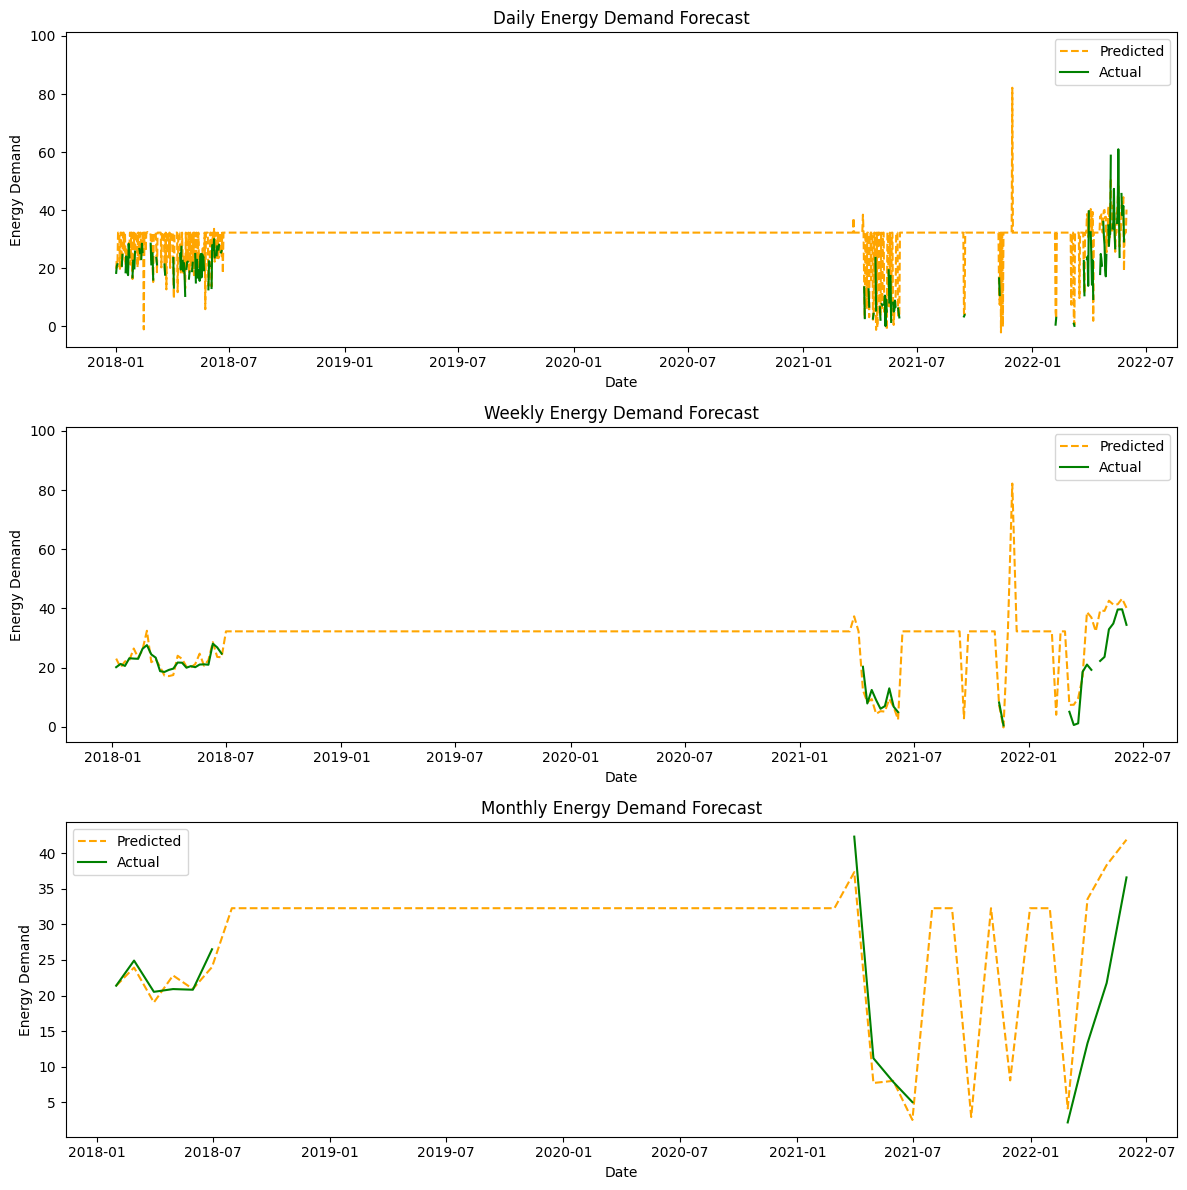

In [ ]:
# Plot the predictions along with the actual data
plt.figure(figsize=(12, 12))

# Daily Forecast
plt.subplot(311)
plt.plot(daily_forecast.index, daily_predictions, label='Predicted', color='orange', linestyle='--')
plt.plot(daily_forecast.index, daily_forecast['Total_Energy_Delivered'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Daily Energy Demand Forecast')
plt.legend()

# Weekly Forecast
plt.subplot(312)
plt.plot(weekly_forecast.index, weekly_predictions, label='Predicted', color='orange', linestyle='--')
plt.plot(weekly_forecast.index, weekly_forecast['Total_Energy_Delivered'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Weekly Energy Demand Forecast')
plt.legend()

# Monthly Forecast
plt.subplot(313)
plt.plot(monthly_forecast.index, monthly_predictions, label='Predicted', color='orange', linestyle='--')
plt.plot(monthly_forecast.index, monthly_forecast['Total_Energy_Delivered'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Monthly Energy Demand Forecast')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
charging_data.sample(10)

,Vehicle_Type,Vehicle_ID,Charger_ID,Local_Charge_Start_Time,Local_Charge_End_Time,Average_Power,Max_Power,Total_Energy_Delivered,Starting_SOC,Ending_SOC,Delta_SOC,Charging_Duration,Range
451,Transit Bus,EV031,CH007-CH008,2018-04-19 10:20:00,2018-04-19 10:27:00,239.570000,360.080000,23.612,66.0,100.0,34.0,0.116667,81.60
788,Transit Bus,EV031,CH007-CH008,2018-01-23 15:22:00,2018-01-23 15:25:00,270.055000,354.500000,14.305,55.5,75.0,19.5,0.050000,46.80
827,Transit Bus,EV031,CH007-CH008,2018-01-20 10:19:00,2018-01-20 10:25:00,315.970000,365.480000,26.849,52.0,87.0,35.0,0.100000,84.00
854,Transit Bus,EV031,CH007-CH008,2018-01-17 16:48:00,2018-01-17 16:50:00,51.103000,180.660000,4.961,32.5,39.5,7.0,0.033333,16.80
258,Transit Bus,EV031,CH007-CH008,2018-05-14 10:21:00,2018-05-14 10:28:00,192.986000,267.500000,21.486,71.5,100.0,28.5,0.116667,68.40
1126,School Bus,EV054,CH009-CH012,2022-04-08 08:45:08,2022-04-08 13:09:08,1.597879,25.174182,7.031,56.4,96.0,39.6,4.400000,95.04
865,Transit Bus,EV031,CH007-CH008,2018-01-15 14:49:00,2018-01-15 14:55:00,285.117000,348.800000,27.421,55.0,90.5,35.5,0.100000,85.20
68,Transit Bus,EV031,CH007-CH008,2018-06-12 12:50:00,2018-06-12 12:56:00,260.268000,297.340000,27.402,55.5,91.0,35.5,0.100000,85.20
649,Transit Bus,EV031,CH007-CH008,2018-02-13 16:14:00,2018-02-13 16:19:00,205.267000,330.360000,20.337,47.5,75.0,27.5,0.083333,66.00
297,Transit Bus,EV031,CH007-CH008,2018-05-09 06:46:00,2018-05-09 06:50:00,206.889000,303.560000,14.991,59.5,81.5,22.0,0.066667,52.80


In [ ]:
evcs_usage= pd.read_csv('EVChargingStationUsage.csv')
# Replace spaces with underscores in column names
evcs_usage.columns = evcs_usage.columns.str.replace(' ', '_')
# Remove the "PALO ALTO CA / " prefix from the 'Station_Name' column
evcs_usage['Station_Name'] = evcs_usage['Station_Name'].str.replace('PALO ALTO CA / ', '')
evcs_usage.sample(10)

,Station_Name,MAC_Address,Org_Name,Start_Date,Start_Time_Zone,End_Date,End_Time_Zone,Transaction_Date_(Pacific_Time),Total_Duration_(hh:mm:ss),Charging_Time_(hh:mm:ss),...,Longitude,Currency,Fee,Ended_By,Plug_In_Event_Id,Driver_Postal_Code,User_ID,County,System_S/N,Model_Number
15260,BRYANT #2,000D6F0000A2108E,City of Palo Alto,9/24/2013 17:05,PDT,9/24/2013 17:07,PDT,9/24/2013 17:07,0:02:17,0:02:04,...,-122.162140,USD,0.00,Plug Out at Vehicle,3439,94303.0,154551.0,NaN,NaN,NaN
159100,BRYANT #6,0024:B100:0002:6B43,City of Palo Alto,4/3/2018 8:04,PDT,4/3/2018 10:01,PDT,4/3/2018 10:02,1:56:53,1:56:39,...,-122.162170,USD,2.08,CPS Server,1473,94924.0,145485.0,Santa Clara County,1.705410e+11,CT4020-HD-GW
135303,WEBSTER #3,0024:B100:0002:4277,City of Palo Alto,8/26/2017 11:08,PDT,8/26/2017 12:15,PDT,8/26/2017 12:15,1:06:19,1:00:45,...,-122.158234,USD,0.74,Plug Out at Vehicle,127,94115.0,843720,Santa Clara County,1.424410e+11,CT4020-HD-GW
152749,HIGH #2,0024:B100:0002:5959,City of Palo Alto,2/6/2018 13:00,PST,2/6/2018 14:07,PST,2/6/2018 14:07,1:06:19,1:05:58,...,-122.163231,USD,1.47,Plug Out at Vehicle,2368,94301.0,747415.0,Santa Clara County,1.640410e+11,CT4020-HD
55718,MPL #4,000D:6F00:04B8:A128,City of Palo Alto,1/28/2016 18:46,PST,1/28/2016 19:07,PST,1/28/2016 19:08,0:20:53,0:20:40,...,-122.113510,USD,0.00,Customer,517,94303.0,482221,NaN,NaN,NaN
70060,HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,5/22/2016 14:51,PDT,5/22/2016 15:47,PDT,5/22/2016 15:47,0:56:26,0:56:19,...,-122.160370,USD,0.00,Plug Out at Vehicle,9770,94086.0,361627,NaN,NaN,NaN
37380,RINCONADA LIB 3,000D6F00015A96E4,City of Palo Alto,5/26/2015 18:42,PDT,5/26/2015 22:24,PDT,5/26/2015 22:24,3:42:15,3:35:41,...,-122.139000,USD,0.00,Plug Out at Vehicle,435,94303.0,380149,NaN,NaN,NaN
215484,WEBSTER #1,0024:B100:0002:4233,City of Palo Alto,7/5/2019 9:01,PDT,7/5/2019 12:11,PDT,7/5/2019 12:12,3:10:06,2:19:16,...,-122.158272,USD,2.15,Plug Out at Vehicle,4805,94588.0,2433971,Santa Clara County,1.336410e+11,CT4020-HD-GW
20669,BRYANT #1,000D6F0000A20D9E,City of Palo Alto,4/2/2014 20:39,PDT,4/3/2014 0:21,PDT,4/3/2014 0:21,3:42:30,3:42:10,...,-122.162308,USD,0.00,Customer,4969,95118.0,221471.0,NaN,NaN,NaN
220281,TED THOMPSON #1,0024:B100:0002:1323,City of Palo Alto,8/12/2019 11:16,PDT,8/12/2019 12:53,PDT,8/12/2019 12:54,1:37:07,1:37:00,...,-122.144188,USD,1.26,Plug Out at Vehicle,7860,94587.0,278189,Santa Clara County,1.427410e+11,CT4020-HD-GW


In [ ]:
evcs_usage.columns

Index(['Station_Name', 'MAC_Address', 'Org_Name', 'Start_Date',
       'Start_Time_Zone', 'End_Date', 'End_Time_Zone',
       'Transaction_Date_(Pacific_Time)', 'Total_Duration_(hh:mm:ss)',
       'Charging_Time_(hh:mm:ss)', 'Energy_(kWh)', 'GHG_Savings_(kg)',
       'Gasoline_Savings_(gallons)', 'Port_Type', 'Port_Number', 'Plug_Type',
       'EVSE_ID', 'Address_1', 'City', 'State/Province', 'Postal_Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended_By',
       'Plug_In_Event_Id', 'Driver_Postal_Code', 'User_ID', 'County',
       'System_S/N', 'Model_Number', 'Date'],
      dtype='object')

In [ ]:
evcs_usage['Postal_Code']

0         94301
1         94301
2         94301
3         94301
4         94301
          ...  
259410    94306
259411    94301
259412    94303
259413    94301
259414    94306
Name: Postal_Code, Length: 259166, dtype: int64

In [ ]:
# Group the data by 'Local_Charge_Start_Time' and calculate the total energy delivered per station per day
station_daily_demand = evcs_usage.groupby('Station_Name')['Energy_(kWh)'].sum()
# store station-wise information
station_info = pd.DataFrame()
station_info['Station_Demand'] = station_daily_demand
station_info['Load_Status'] = ''
station_info['Number_of_Vehicles_Charged'] = 0  # Initialize to 0

threshold = 10000

for station in station_info.index:
    demand = station_info.at[station, 'Station_Demand']
    if demand > threshold:
        station_info.at[station, 'Load_Status'] = 'Overloaded'
    else:
        station_info.at[station, 'Load_Status'] = 'Sufficient'

In [ ]:
# Convert 'Transaction_Date_(Pacific_Time)' to a datetime object
evcs_usage['Transaction_Date_(Pacific_Time)'] = pd.to_datetime(evcs_usage['Transaction_Date_(Pacific_Time)'], errors='coerce')

# Filter out rows with invalid or incorrect data
evcs_usage = evcs_usage.dropna(subset=['Transaction_Date_(Pacific_Time)'])

In [ ]:
# Group the data by 'Station_Name' and date to calculate the daily demand and number of vehicles charged
evcs_usage['Date'] = evcs_usage['Transaction_Date_(Pacific_Time)'].dt.date
grouped_data = evcs_usage.groupby(['Station_Name', 'Date'])

# Calculate the daily demand (sum of 'Energy_(kWh)') and number of vehicles charged per day
daily_demand_and_vehicles = grouped_data.agg({'Energy_(kWh)': 'sum', 'MAC_Address': 'nunique'}).reset_index()

# Rename the columns for clarity
daily_demand_and_vehicles.columns = ['Station_Name', 'Date', 'Daily_Demand_kWh', 'Number_of_Vehicles_Charged']

# Define a threshold for load status (adjust as needed)
threshold = 20 # Adjust this threshold as needed

# Add a 'Load_Status' column based on the threshold
daily_demand_and_vehicles['Load_Status'] = daily_demand_and_vehicles['Daily_Demand_kWh'].apply(
    lambda demand: 'Overloaded' if demand > threshold else 'Sufficient'
)

# Iterate through the DataFrame and print the station details including the status
for index, row in daily_demand_and_vehicles.iterrows():
    station_name = row['Station_Name']
    date = row['Date']
    daily_demand = row['Daily_Demand_kWh']
    num_vehicles = row['Number_of_Vehicles_Charged']
    load_status = row['Load_Status']

    print(f"Station Name: {station_name}")
    print(f"Date: {date}")
    print(f"Daily Demand (kWh): {daily_demand}")
    print(f"Number of Vehicles Charged: {num_vehicles}")
    print(f"Load Status: {load_status}")
    print("\n")

Streaming output truncated to the last 5000 lines.


Station Name: WEBSTER #3
Date: 2018-09-25
Daily Demand (kWh): 55.909
Number of Vehicles Charged: 1
Load Status: Overloaded


Station Name: WEBSTER #3
Date: 2018-09-26
Daily Demand (kWh): 94.634
Number of Vehicles Charged: 1
Load Status: Overloaded


Station Name: WEBSTER #3
Date: 2018-09-27
Daily Demand (kWh): 46.903
Number of Vehicles Charged: 1
Load Status: Overloaded


Station Name: WEBSTER #3
Date: 2018-09-28
Daily Demand (kWh): 43.973
Number of Vehicles Charged: 1
Load Status: Overloaded


Station Name: WEBSTER #3
Date: 2018-09-29
Daily Demand (kWh): 42.013999999999996
Number of Vehicles Charged: 1
Load Status: Overloaded


Station Name: WEBSTER #3
Date: 2018-09-30
Daily Demand (kWh): 17.611
Number of Vehicles Charged: 1
Load Status: Sufficient


Station Name: WEBSTER #3
Date: 2018-10-01
Daily Demand (kWh): 36.902
Number of Vehicles Charged: 1
Load Status: Overloaded


Station Name: WEBSTER #3
Date: 2018-10-02
Daily Demand (kWh)

In [ ]:
daily_demand_and_vehicles

,Station_Name,Date,Daily_Demand_kWh,Load_Status
0,BRYANT # 1,2020-09-06,5.355,Sufficient
1,BRYANT # 1,2020-09-07,5.297,Sufficient
2,BRYANT # 1,2020-10-13,4.361,Sufficient
3,BRYANT # 1,2020-10-15,42.064,Overloaded
4,BRYANT # 1,2020-10-17,16.092,Sufficient
...,...,...,...,...
55178,WEBSTER #3,2020-12-25,9.897,Sufficient
55179,WEBSTER #3,2020-12-26,10.359,Sufficient
55180,WEBSTER #3,2020-12-29,37.291,Overloaded
55181,WEBSTER #3,2020-12-30,47.706,Overloaded


In [ ]:
# Group the data by 'Station_Name' and date to calculate the daily demand and number of vehicles charged
evcs_usage['Date'] = evcs_usage['Transaction_Date_(Pacific_Time)'].dt.date
grouped_data = evcs_usage.groupby(['Postal_Code', 'Date'])

# Calculate the daily demand (sum of 'Energy_(kWh)') and number of vehicles charged per day
daily_demand_and_vehicles_zc = grouped_data.agg({'Energy_(kWh)': 'sum', }).reset_index()

# Rename the columns for clarity
daily_demand_and_vehicles_zc.columns = ['Postal_Code', 'Date', 'Daily_Demand_kWh']

# Define a threshold for load status (adjust as needed)
threshold = 40 # Adjust this threshold as needed

# Add a 'Load_Status' column based on the threshold
daily_demand_and_vehicles_zc['Load_Status'] = daily_demand_and_vehicles_zc['Daily_Demand_kWh'].apply(
    lambda demand: 'Overloaded' if demand > threshold else 'Sufficient'
)

# Iterate through the DataFrame and print the station details including the status
for index, row in daily_demand_and_vehicles_zc.iterrows():
    zip_code = row['Postal_Code']
    date = row['Date']
    daily_demand = row['Daily_Demand_kWh']
    load_status = row['Load_Status']

    print(f"Zip Code: {zip_code}")
    print(f"Date: {date}")
    print(f"Daily Demand (kWh): {daily_demand}")
    print(f"Load Status: {load_status}")
    print("\n")

Streaming output truncated to the last 5000 lines.


Zip Code: 94306
Date: 2018-09-18
Daily Demand (kWh): 314.762
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-19
Daily Demand (kWh): 310.055
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-20
Daily Demand (kWh): 359.813
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-21
Daily Demand (kWh): 312.595
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-22
Daily Demand (kWh): 174.426
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-23
Daily Demand (kWh): 82.072
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-24
Daily Demand (kWh): 292.412
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-25
Daily Demand (kWh): 280.46500000000003
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-26
Daily Demand (kWh): 355.759
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-27
Daily Demand (kWh): 306.71
Load Status: Overloaded


Zip Code: 94306
Date: 2018-09-28
Daily Demand (kWh): 255.06799999999

In [ ]:
daily_demand_and_vehicles_zc

,Postal_Code,Date,Daily_Demand_kWh,Load_Status
0,94301,2011-07-29,6.249457,Sufficient
1,94301,2011-07-30,24.175773,Sufficient
2,94301,2011-07-31,42.012043,Overloaded
3,94301,2011-08-01,5.041244,Sufficient
4,94301,2011-08-02,16.210423,Sufficient
...,...,...,...,...
7535,94306,2020-12-27,77.270000,Overloaded
7536,94306,2020-12-28,138.805000,Overloaded
7537,94306,2020-12-29,84.101000,Overloaded
7538,94306,2020-12-30,56.797000,Overloaded
